In [1]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import datetime
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing  
from pandas import DataFrame
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.ticker import MultipleLocator 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

In [2]:
path = os.getcwd().split('TianChi_IJCAI-17_footfall_prediction_code')[0]

#shop_info = pd.read_table(path+'dataset/shop_info.txt',names=['shop_id','city_name','location_id','per_pay','score','comment_cnt','shop_level','cate_1_name','cate_2_name','cate_3_name'],header=None,delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info = pd.read_table(path+'dataset/shop info with count.csv',delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info.index = shop_info['shop_id'].tolist()

In [5]:
def dateRange(start, end):
    days = (datetime.datetime.strptime(end, "%Y-%m-%d") - datetime.datetime.strptime(start, "%Y-%m-%d")).days + 1
    return [datetime.datetime.strftime(datetime.datetime.strptime(start, "%Y-%m-%d") + datetime.timedelta(i), "%Y-%m-%d") for i in xrange(days)]

def draw_week_id(id,start_date='wk_0',end_date='wk_68',figsieze=(16,9)):
    shop_info.loc[id,start_date:end_date].T.plot(figsize=(16,9))
def draw_week_ids(ids,start_date='wk_0',end_date='wk_68',figsieze=(16,9)):
    shop_info.loc[ids,start_date:end_date].T.plot(figsize=(16,9))
def draw_ids(ids,dataset=shop_info,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):
    if by_week:
        xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
        dataset.loc[ids,start_date:end_date].T.plot(figsize=figsize,ax=ax)
    else: dataset.loc[ids,start_date:end_date].T.plot(figsize=figsize)
    plt.show()
def draw_ids_avg(ids,start_date='2015-07-01',end_date='2016-10-31',by_week=True,figsize=(70,10)):
    if by_week:
        xmajorLocator   = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    shop_info.loc[ids,start_date:end_date].mean(axis=0).plot(figsize=figsize)
    plt.show()
def draw_ids_diff(ids,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):  
    if by_week:
        xmajorLocator   = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    (shop_info.loc[ids[0],start_date:end_date]-shop_info.loc[ids[1],start_date:end_date]).plot(figsize=figsize)
def draw_id(id,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):
    if by_week:
        xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    shop_info.loc[id,start_date:end_date].plot(legend=True,figsize=figsize)



# Data Cleaning

#### 填充最后4周出现单次零值状况

In [150]:
ids_zero_1_count_in_last_three_week = [513, 987, 1163, 524, 397, 18, 1556, 1688, 5, 1185, 1700, 1959, 683, 1715, 958, 480, 707, 459, 1486, 1831, 722, 735, 352, 363, 1661, 1918]
clean_day = dateRange('2016-10-11','2016-10-31')
clean_day.extend(dateRange('2016-09-20','2016-09-26'))
for day in clean_day:
    for id in ids_zero_1_count_in_last_three_week:
        if shop_info.loc[id,day] == 0:
            day_offset = (pd.to_datetime(day).date() - datetime.date(2016,10,11)).days % 7 
            rel_days = []
            for rel_day in dateRange('2016-10-11','2016-10-31'):
                if (pd.to_datetime(rel_day).date() - datetime.date(2016,10,11)).days % 7 == day_offset and rel_day != day:
                    rel_days.append(shop_info.loc[id,rel_day])
            rel_days = np.array(rel_days)
            shop_info.loc[id,day] = np.int64(rel_days.mean()+0.5)

In [173]:
days={}
for day in clean_day:
    offset = (pd.to_datetime(day).date() - datetime.date(2016,10,11)).days % 7
    if offset not in days:
        days[offset] = []
    days[offset].append(day)
     

In [178]:
ids_zero_morethan1_count_in_last_three_week = [2, 1707, 1925, 1418, 659, 1053, 1797, 1824, 547, 810, 432, 1459, 1462, 1464, 1465, 700, 191, 1858, 1993, 1109, 470,1243, 1380, 444, 1269, 632]

for id in ids_zero_morethan1_count_in_last_three_week:
    for day in clean_day:
        if shop_info.loc[id,day] == 0:
            offset = (pd.to_datetime(day).date() - datetime.date(2016,10,11)).days % 7
            rel_days = []
            rel_days.extend(days[offset])
            for i in rel_days:
                if shop_info.loc[id,i] == 0:
                    rel_days.remove(i)
            print shop_info.loc[id,rel_days].median()
            shop_info.loc[id,day] = shop_info.loc[id,rel_days].median()

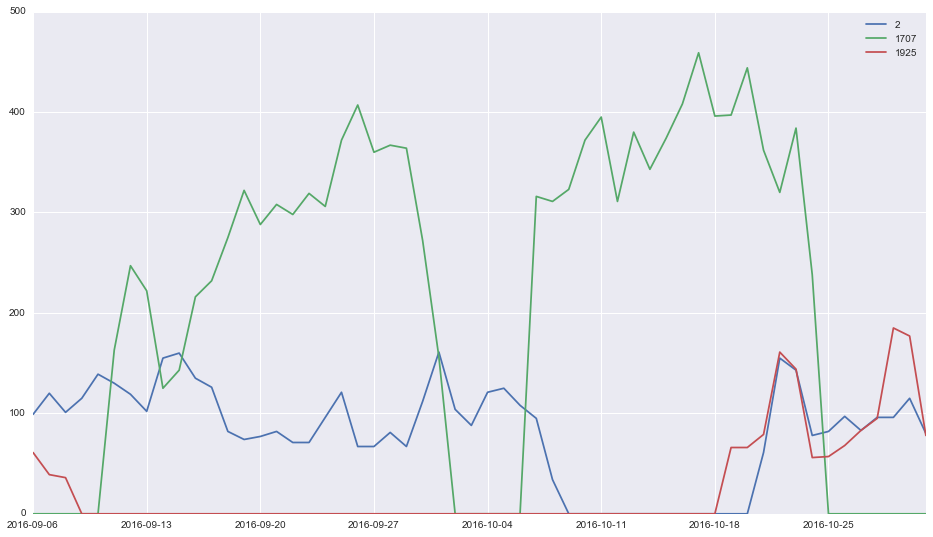

In [177]:
draw_ids(ids_zero_morethan1_count_in_last_three_week[:3],start_date='2016-09-06',by_week=True)

# train

In [7]:
shop_info_num = shop_info.iloc[:,:10].copy()

In [8]:
weekA = shop_info.loc[:,'2016-09-20':'2016-09-26'].copy()
weekB = shop_info.loc[:,'2016-10-11':'2016-10-17'].copy()
weekC = shop_info.loc[:,'2016-10-18':'2016-10-24'].copy()
weekD = shop_info.loc[:,'2016-10-25':'2016-10-31'].copy()

In [9]:
'''  poly   degree=2     '''
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False)
train_x = weekA.join(weekB)                                    #train = weekA+ weekB + weekC
train_x = train_x.join(weekC)

In [10]:

def every_shop_open_ratio(start_day,end_day):
    Row = len(shop_info.index.tolist())
    row = 0
    Open_ratios = []
    while(row<Row):
        single_row = shop_info.iloc[row]
        single_row = single_row[start_day:end_day]
        open_ratio_ = (single_row>0).sum()/float((pd.to_datetime(end_day).date()-pd.to_datetime(start_day).date()).days+1)
        Open_ratios.append(round(open_ratio_,4))
        row = row+1
    Open_ratios = np.array(Open_ratios)
 
  
    mask = Open_ratios>=0
    df = DataFrame({'shop_id':(shop_info.shop_id)[mask].values,'open_ratio':Open_ratios[mask]},index=np.arange(1,2001))
    return  df   #返回大于threshold的shop_id,以及他们对应的开张比例


In [11]:
train_sum = train_x.sum(axis=1)
train_mean = train_x.mean(axis=1)
train_open_ratio_A = every_shop_open_ratio(start_day='2016-09-20',end_day='2016-09-26')
train_open_ratio_BC = every_shop_open_ratio(start_day='2016-10-11',end_day='2016-10-24')
train_open_ratio = (train_open_ratio_A.open_ratio + train_open_ratio_BC.open_ratio*2)/3
train_weekend = ['2016-09-24','2016-09-25','2016-10-15','2016-10-16','2016-10-22','2016-10-23']
train_ratio_wk = (train_x[train_weekend]).sum(axis=1)/(train_sum.replace(0,1))
train_std = train_x.std(axis=1)
train_max = train_x.max(axis=1)
train_min = train_x.min(axis=1)
train_median = train_x.median(axis=1)
train_mad = train_x.mad(axis=1)
train_var = train_x.var(axis=1) 

In [12]:
'''将多维数组转换为DataFrame'''
def transfrom_Arr_DF(arr,col_name = 'col_'):
    if(len(arr.shape)==1):
        df = DataFrame(arr,columns=['col_0'])
    else:
        df = DataFrame(arr,columns=[col_name+str(i) for i in range(arr.shape[1])],index=np.arange(1,len(arr)+1))
    return df

'''将一维数组转换为OHE码'''
def make_OHE(names):
    data = []
    for name in names:
        data.append([name])          
    enc = preprocessing.OneHotEncoder()
    enc.fit(data)
    OHE_data = enc.transform(data).toarray()  
    return OHE_data


In [13]:
shop_info_num['score'].replace(np.NaN,-1.0,inplace=True)
shop_info_num['comment_cnt'].replace(np.NaN,-1.0,inplace=True)
shop_info_num['cate_3_name'].replace(np.NaN,u'NaN',inplace=True)

In [14]:
city_name_usual=[u'上海',u'杭州',u'北京',u'广州',u'南京',u'武汉',u'深圳']
shop_info_num.loc[~shop_info_num['city_name'].isin(city_name_usual),'city_name'] = u'其他城市'
cate_1_name_usual=[u'美食',u'超市便利店']
shop_info_num.loc[~shop_info_num['cate_1_name'].isin(cate_1_name_usual),'cate_1_name'] = u'其他'
cate_2_name_usual=[u'快餐',u'超市',u'便利店',u'休闲茶饮',u'小吃',u'休闲食品',u'烘焙糕点',u'中餐',u'其他美食',u'火锅']
shop_info_num.loc[~shop_info_num['cate_2_name'].isin(cate_2_name_usual),'cate_2_name'] = u'其他'
cate_3_name_usual=[u'西式快餐',u'中式快餐',u'生鲜水果',u'奶茶',u'其它小吃',u'面包',u'饮品/甜点',u'面点',u'蛋糕']
shop_info_num.loc[~shop_info_num['cate_3_name'].isin(cate_3_name_usual),'cate_3_name'] = u'其他'


In [15]:
train_x = transfrom_Arr_DF(poly.fit_transform(train_x))

In [16]:

train_x['sumABCD'] = train_sum
train_x['open_ratio'] = train_open_ratio
train_x['ratio_wk'] = train_ratio_wk
train_x['meanABCD'] = train_mean
train_x['std'] = train_std
train_x['max'] = train_max
train_x['min'] = train_min
train_x['median'] = train_median
train_x['mad'] = train_mad
train_x['var'] = train_var

In [17]:
train_x = train_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [18]:
train_x = train_x.join(shop_info_num['location_id'])
train_x = train_x.join(shop_info_num['comment_cnt'])

In [19]:
#加入userview
user_view = pd.read_csv(path+'dataset/shop view separately.csv',index_col=0)

,view_2016-09-20,view_2016-09-21,view_2016-09-22,view_2016-09-23,view_2016-09-24,view_2016-09-25,view_2016-09-26
1,31,20,22,31,25,18,25
2,26,30,30,28,40,40,29
3,6,0,4,2,3,8,2
4,30,22,25,20,57,37,29
5,6,9,4,1,3,5,3
6,6,2,4,6,4,5,12
7,16,23,12,11,14,16,11
8,10,10,7,4,7,10,15
9,7,10,9,8,10,13,11
10,0,1,1,0,1,1,0


In [20]:
view_weekA = user_view.loc[:,'view_2016-09-20':'view_2016-09-26'].copy()
view_weekB = user_view.loc[:,'view_2016-10-11':'view_2016-10-17'].copy()
view_weekC = user_view.loc[:,'view_2016-10-18':'view_2016-10-24'].copy()
view_weekD = user_view.loc[:,'view_2016-10-25':'view_2016-10-31'].copy()

In [21]:
train_x = train_x.join(view_weekA)
train_x = train_x.join(view_weekB)
train_x = train_x.join(view_weekC)

In [22]:
#加入stable_day_

In [23]:
stable_wave_model = pd.read_csv('stable_wave_model.csv',index_col=0)

In [24]:
train_x = train_x.join(stable_wave_model)

In [25]:
#加入3周余弦相似度 与 近似商家wave

wk1=['2016-09-20','2016-09-26']
wk2=['2016-10-11','2016-10-17']
wk3=['2016-10-18','2016-10-24']

def cal_cos_sim_between(x,wka,wkb):
    wka_vec =  np.array(x[wka[0]:wka[1]].tolist())
    wkb_vec =  np.array(x[wkb[0]:wkb[1]].tolist())
    sim = wka_vec.dot(wkb_vec) / (np.sqrt(np.sum(np.square(wka_vec))) * np.sqrt(np.sum(np.square(wkb_vec))))
    return sim
train_x['cos_sim_between_wk_1_2'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk2),axis=1)
train_x['cos_sim_between_wk_2_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk2,wk3),axis=1)
train_x['cos_sim_between_wk_1_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk3),axis=1)

train_x['cos_sim_between_wk_1_2'].replace(np.NaN,0.0,inplace=True)
train_x['cos_sim_between_wk_2_3'].replace(np.NaN,0.0,inplace=True)
train_x['cos_sim_between_wk_1_3'].replace(np.NaN,0.0,inplace=True)

In [305]:
# 加入趋势特征

In [ ]:
#加入天气

In [26]:
weather = pd.read_csv('shop_weather.csv',index_col=0)

In [28]:
train_x = train_x.join(weather.loc[:,'weather_2016-09-20':'weather_2016-10-31'])

In [71]:
train_x

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,wave_model2_2,wave_model2_3,wave_model2_4,wave_model2_5,wave_model2_6,wave_model2_7,ids_stable_period_1,ids_stable_period_2,ids_stable_period_3,ids_no_stable_period
1,223.0,206.0,220.0,241.0,272.0,240.0,225.0,254.0,239.0,228.0,...,233.500000,245.916667,257.750000,250.833333,234.416667,233.833333,1,0,0,0
2,77.0,82.0,71.0,71.0,96.0,121.0,67.0,0.0,0.0,0.0,...,96.250000,83.375000,90.125000,117.500000,123.000000,91.750000,1,0,0,0
3,62.0,59.0,55.0,79.0,112.0,83.0,88.0,68.0,63.0,56.0,...,71.142857,66.285714,73.428571,81.142857,84.571429,69.000000,0,1,0,0
4,74.0,101.0,102.0,98.0,203.0,199.0,91.0,86.0,113.0,71.0,...,115.428571,102.857143,114.857143,201.714286,220.142857,110.142857,0,1,0,0
5,277.0,272.0,309.0,182.0,179.0,4.0,305.0,223.0,218.0,230.0,...,269.000000,260.285714,217.142857,215.428571,197.142857,309.000000,0,0,1,0
6,77.0,68.0,74.0,73.0,67.0,89.0,83.0,83.0,91.0,90.0,...,46.600000,49.000000,62.400000,57.800000,58.600000,59.000000,0,1,0,0
7,105.0,116.0,105.0,141.0,168.0,180.0,109.0,136.0,93.0,128.0,...,152.200000,170.200000,184.800000,166.000000,212.000000,162.000000,1,0,0,0
8,62.0,65.0,57.0,71.0,69.0,73.0,55.0,81.0,63.0,65.0,...,106.500000,88.000000,95.250000,92.750000,86.000000,75.250000,0,1,0,0
9,238.0,214.0,229.0,242.0,288.0,324.0,212.0,225.0,202.0,192.0,...,205.520000,197.320000,203.760000,230.080000,238.040000,200.160000,1,0,0,0
10,73.0,104.0,69.0,76.0,73.0,89.0,80.0,108.0,111.0,73.0,...,66.000000,50.600000,52.600000,57.400000,72.400000,61.400000,0,0,1,0


#### train_y

In [29]:
train_y = weekD

### 检查 train_x train_y 是否符合要求 不包含NaN

In [30]:
 def fresh_ids():
    ids = range(1,2001)
    np.random.shuffle(ids)
    #print ids
    train_set_ids = ids[:1600]
    val_set_ids = ids[1600:]
    return train_set_ids,val_set_ids

In [ ]:
feature_list = [i for i in train_x.columns.tolist() if i not in ['col_'+str(num) for num in range(21,231)]]


## RF

In [173]:
train_set_ids,val_set_ids = fresh_ids()
train_set_ids =range(401,2001)
val_set_ids = range(1,401)
RF = RandomForestRegressor(n_estimators=1600,
                            random_state=1,
                            n_jobs=-1,
                            min_samples_split=2,
                            min_samples_leaf=2,)
#print RF.score(train_x,train_y)
RF.fit(train_x.loc[train_set_ids,:],train_y.loc[train_set_ids,:])
print RF.score(train_x,train_y)
predict_val = pd.DataFrame(RF.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_val.loc[:,'predict_'+str(i)] = predict_val.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

train_score = 0.0
for id in val_set_ids:
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id-1,day] - predict_val.iloc[id-1,day]))/(train_y.iloc[id-1,day] + predict_val.iloc[id-1,day])/(7*400)
print train_score

0.95380823735
0.0738834510453


 train_score add location_id & comment_cnt
0.0770314034279
0.0779705913349
0.078948579937
0.0797655132658
0.0827867281122
0.0830453170442
0.0875721485457  -- 0.954111600465
0.0833575682115 
0.081675846769
0.0830629914982 
 加入 userview
0.0751307632343
0.0764668232205
0.0781205661011
 1600,400
0.0878128199044
 加入 三周余弦相似度（drop)
0.0878918600216
 加入 天气
0.0876963924706
 换个划分

## ET

In [174]:
train_set_ids,val_set_ids = fresh_ids()
train_set_ids =range(401,2001)
val_set_ids = range(1,401)
ET = ExtraTreesRegressor(n_estimators=1600,
                           random_state=1,
                           n_jobs=-1,
                           min_samples_split=2,
                           min_samples_leaf=2,
                           max_depth=25,
                           max_features='auto')
ET.fit(train_x.loc[train_set_ids,:],train_y.loc[train_set_ids,:])

predict_val = pd.DataFrame(ET.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_val.loc[:,'predict_'+str(i)] = predict_val.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

train_score = 0.0
for id in val_set_ids:
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id-1,day] - predict_val.iloc[id-1,day]))/(train_y.iloc[id-1,day] + predict_val.iloc[id-1,day])/(7*400)
print train_score


0.0734360521763


#### train_score add location_id & comment_cnt

0.081000335966
0.0798722568859
0.0775547455471 

#### 加入 stable wave model max_features=290
0.0799956351718
0.0856649743061
0.0814708388275
0.0834221709742
#### 加入 userview
0.0800946904414
0.0820529531944
0.0817082217219
#### 1600,400
0.0867150894683
#### 加入 三周余弦相似度
0.0867362577526
####  max_features='auto'
0.0866585563586
####  天气
0.0865599468872
#### 换个划分

## 看看训练时的error都出在什么id上，是否要制定规则

In [113]:
ids_high_error = []
for id in range(2000):
    train_score = 0.0
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id,day] - predict_train.iloc[id,day]))/(train_y.iloc[id,day] + predict_train.iloc[id,day])/(7)
    #print id+1,train_score
    if train_score > 0.2:
        ids_high_error.append(id+1)
        

In [114]:
ids_high_error

[5,
 23,
 352,
 444,
 459,
 470,
 524,
 561,
 632,
 659,
 810,
 1058,
 1163,
 1185,
 1218,
 1243,
 1384,
 1407,
 1418,
 1526,
 1556,
 1650,
 1707,
 1716,
 1824,
 1856,
 1858,
 1918]

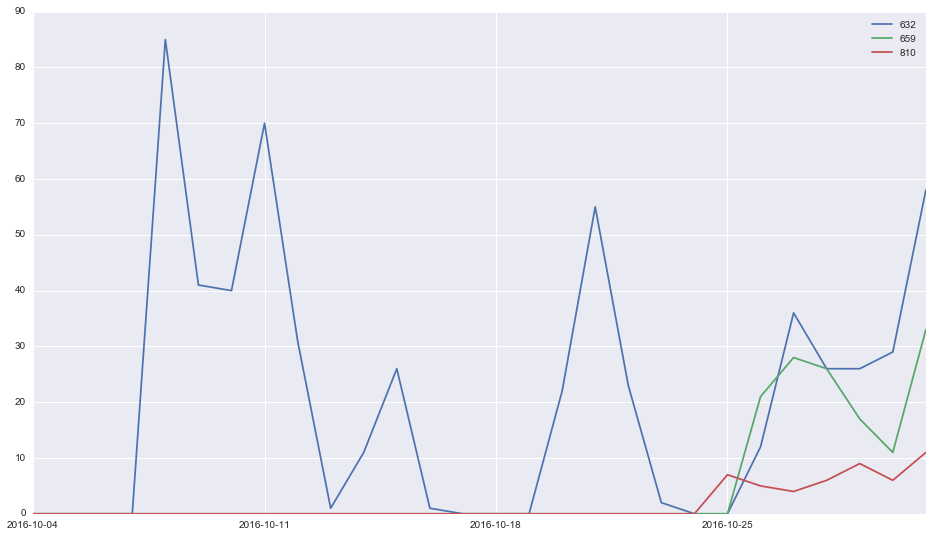

In [124]:
draw_ids(ids_high_error[8:11],dataset=shop_info,start_date = '2016-10-04',by_week=True)

In [99]:
train_predict_find_error = pd.DataFrame(ET.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])

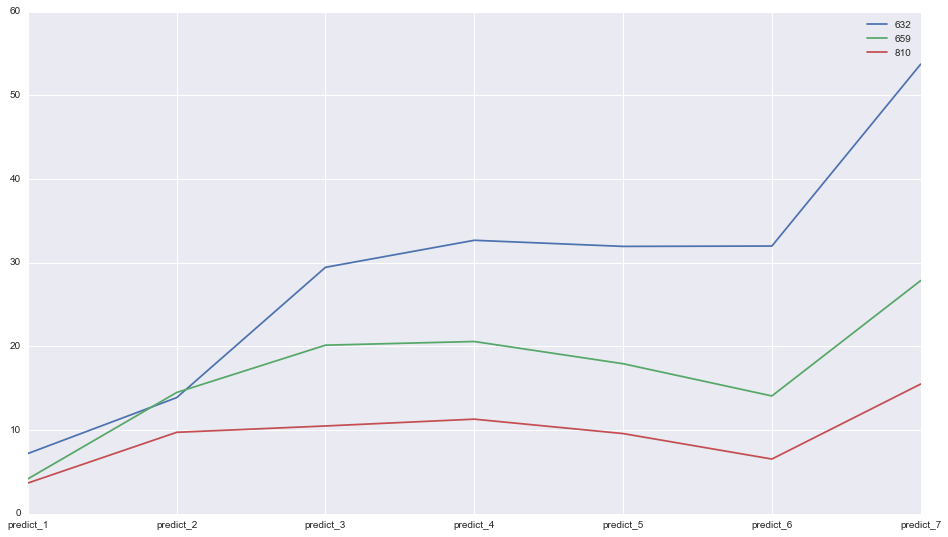

In [122]:
draw_ids(ids_high_error[8:11],dataset=train_predict_find_error ,start_date = 'predict_1',end_date='predict_7')

### 开始训练

## RF

In [31]:
RF = RandomForestRegressor(n_estimators=1600,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=None)
RF.fit(train_x,train_y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1600, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

## ET

In [32]:
ET = ExtraTreesRegressor(n_estimators=1600,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=25,max_features=None)
ET.fit(train_x,train_y)


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=25,
          max_features=None, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=2, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=-1,
          oob_score=False, random_state=1, verbose=0, warm_start=False)

## GBDT

In [33]:
GBDT = []
for i in train_y.columns: 
    g = GradientBoostingRegressor(loss='huber')
    g.fit(train_x,train_y[i])
    GBDT.append(g)

In [34]:
RF.score(train_x,train_y)

0.96652303038683252

0.96566366376351054 max_depth = 25 / none n_estimators=1200
0.96595 n_estimators=1600
0.96602585097285765  加入 stable wave model
 加入 userview
0.96589687506866584
  加入 三周余弦相似度 （dropped)
0.96601672768808777 
 天气
0.96604498211593814
 单个零点修正
0.96652303038683252

In [35]:
ET.score(train_x,train_y)

0.98445876781313557

0.98402907280130347 no max_features
0.98404200338521919 max_features=270
0.98403486778744087  加入 stable wave model
0.98406360722194519 max_features=280
0.98408096361968167  max_features=290
 加入 userview
0.98408958618737985
 加入 三周余弦相似度 (dropped)
0.98407059228426352
max_features=300
0.98413913215600435
max_features=none
0.98419761469576117
 天气
0.98425916547308967
 单个零点修正
0.98445876781313557

In [36]:
np.mean([GBDT[n].score(train_x,train_y.iloc[:,n]) for n in range(len(GBDT))])

0.97033325758269917

0.96885431869673655
 单个零点修正
0.97033325758269917

### 查看比赛定义的训练成绩（仅1周的）

In [128]:
train_y

,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
1,255,172,226,257,251,281,180
2,82,97,83,96,96,115,80
3,80,61,68,103,102,104,67
4,90,104,55,110,215,196,115
5,302,1,0,215,203,291,239
6,97,100,117,133,109,118,86
7,128,115,111,128,165,162,81
8,70,68,72,49,70,71,35
9,210,197,245,205,291,283,212
10,77,114,85,84,99,93,121


In [85]:
predict_train = pd.DataFrame(RF.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_train.loc[:,'predict_'+str(i)] = predict_train.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

In [82]:
predict_train = pd.DataFrame(ET.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_train.loc[:,'predict_'+str(i)] = predict_train.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

In [86]:
train_score = 0.0
for id in range(2000):
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id,day] - predict_train.iloc[id,day]))/(train_y.iloc[id,day] + predict_train.iloc[id,day])/(7*2000)
        
        

In [87]:
train_score

0.046010419541393226

In [ ]:
0.046128191132625
0.04603659731204112 (rf)
0.029443343537153256 (et)
0.046010419541393226 (rf) add weather
0.02912634783553982 (et)

### feature importance

In [125]:
pd.concat((pd.DataFrame(train_x.columns, columns = ['variable']), 
           pd.DataFrame(RF.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('RF_feature_importance_.csv', sep=",", index = False)
pd.concat((pd.DataFrame(train_x.columns, columns = ['variable']), 
           pd.DataFrame(ET.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('ET_feature_importance_.csv', sep=",", index = False)

# offline test :  

In [184]:
train_score = 0.0
for id in range(2000):
    for day in range(7):
        train_score += float(np.fabs(weekD.iloc[id,day] - result.iloc[id,day]))/(weekD.iloc[id,day] + result.iloc[id,day])/(7*2000)
        
print train_score

IndexError: single positional indexer is out-of-bounds

# test

In [37]:
test_x = weekB.join(weekC)                                         #test = weekB + weekC + weekD 
test_x = test_x.join(weekD)


test_sum = test_x.sum(axis=1)
test_mean = test_x.mean(axis=1)
test_open_ratio = every_shop_open_ratio(start_day='2016-10-11',end_day='2016-10-31')
test_weekend = ['2016-10-15','2016-10-16','2016-10-22','2016-10-23','2016-10-29','2016-10-30']
test_ratio_wk = (test_x[test_weekend]).sum(axis=1)/(test_sum.replace(0,1))
test_std = test_x.std(axis=1)
test_max = test_x.max(axis=1)
test_min = test_x.min(axis=1)
test_median = test_x.median(axis=1)
test_mad = test_x.mad(axis=1)
test_var = test_x.var(axis=1)



In [38]:
test_x = transfrom_Arr_DF(poly.fit_transform(test_x))

test_x['sumABCD'] = test_sum
test_x['open_ratio'] = test_open_ratio.open_ratio
test_x['ratio_wk'] = test_ratio_wk
test_x['meanABCD'] = test_mean
test_x['std'] = test_std
test_x['max'] = test_max
test_x['min'] = test_min
test_x['median'] = test_median
test_x['mad'] = test_mad
test_x['var'] = test_var

In [39]:
test_x = test_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [40]:
test_x = test_x.join(shop_info_num['location_id'])
test_x = test_x.join(shop_info_num['comment_cnt'])

In [41]:


test_x = test_x.join(view_weekB)
test_x = test_x.join(view_weekC)
test_x = test_x.join(view_weekD)


In [42]:
test_x = test_x.join(stable_wave_model)

In [43]:
test_x = test_x.join(weather.loc[:,'weather_2016-10-11':'weather_2016-11-07'])

In [ ]:
"""
wk1=['2016-10-11','2016-10-17']
wk2=['2016-10-18','2016-10-24']
wk3=['2016-10-25','2016-10-31']
def cal_cos_sim_between(x,wka,wkb):
    wka_vec =  np.array(x[wka[0]:wka[1]].tolist())
    wkb_vec =  np.array(x[wkb[0]:wkb[1]].tolist())
    sim = wka_vec.dot(wkb_vec) / (np.sqrt(np.sum(np.square(wka_vec))) * np.sqrt(np.sum(np.square(wkb_vec))))
    return sim
test_x['cos_sim_between_wk_1_2'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk2),axis=1)
test_x['cos_sim_between_wk_2_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk2,wk3),axis=1)
test_x['cos_sim_between_wk_1_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk3),axis=1)

test_x['cos_sim_between_wk_1_2'].replace(np.NaN,0.0,inplace=True)
test_x['cos_sim_between_wk_2_3'].replace(np.NaN,0.0,inplace=True)
test_x['cos_sim_between_wk_1_3'].replace(np.NaN,0.0,inplace=True)
"""

## 检查是否columns是否相同

In [44]:
for i in range(len(train_x.columns.tolist())):
    if train_x.columns.tolist()[i] != test_x.columns.tolist()[i]:
        print train_x.columns.tolist()[i],test_x.columns.tolist()[i]

view_2016-09-20 view_2016-10-11
view_2016-09-21 view_2016-10-12
view_2016-09-22 view_2016-10-13
view_2016-09-23 view_2016-10-14
view_2016-09-24 view_2016-10-15
view_2016-09-25 view_2016-10-16
view_2016-09-26 view_2016-10-17
view_2016-10-11 view_2016-10-18
view_2016-10-12 view_2016-10-19
view_2016-10-13 view_2016-10-20
view_2016-10-14 view_2016-10-21
view_2016-10-15 view_2016-10-22
view_2016-10-16 view_2016-10-23
view_2016-10-17 view_2016-10-24
view_2016-10-18 view_2016-10-25
view_2016-10-19 view_2016-10-26
view_2016-10-20 view_2016-10-27
view_2016-10-21 view_2016-10-28
view_2016-10-22 view_2016-10-29
view_2016-10-23 view_2016-10-30
view_2016-10-24 view_2016-10-31
weather_2016-09-20 weather_2016-10-11
weather_2016-09-21 weather_2016-10-12
weather_2016-09-22 weather_2016-10-13
weather_2016-09-23 weather_2016-10-14
weather_2016-09-24 weather_2016-10-15
weather_2016-09-25 weather_2016-10-16
weather_2016-09-26 weather_2016-10-17
weather_2016-10-11 weather_2016-10-18
weather_2016-10-12 weath

In [45]:
result = ET.predict(test_x)
pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)]).to_csv('regression_prediction.csv', sep=",", index = True)

In [46]:
result = pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])

## 预测第二周 相比于第一周更换了天气特征～

In [51]:
test_x_2 = test_x.copy()

In [52]:
for i in ['weather_'+ date for date in dateRange('2016-10-11','2016-11-07')]:
    del test_x_2[i]

In [53]:
test_x_2 = test_x_2.join(weather.loc[:,'weather_2016-10-11':'weather_2016-10-31'])
test_x_2 = test_x_2.join(weather.loc[:,'weather_2016-11-08':'weather_2016-11-14'])

In [55]:
for i in range(len(test_x_2.columns.tolist())):
    if test_x_2.columns.tolist()[i] != test_x.columns.tolist()[i]:
        print test_x_2.columns.tolist()[i],test_x.columns.tolist()[i]

weather_2016-11-08 weather_2016-11-01
weather_2016-11-09 weather_2016-11-02
weather_2016-11-10 weather_2016-11-03
weather_2016-11-11 weather_2016-11-04
weather_2016-11-12 weather_2016-11-05
weather_2016-11-13 weather_2016-11-06
weather_2016-11-14 weather_2016-11-07


In [56]:
result2 = ET.predict(test_x_2)
result2 = pd.DataFrame(result2,index=range(1,2001),columns=['predict_'+str(i) for i in range(8,15)])


In [57]:
result2

,predict_8,predict_9,predict_10,predict_11,predict_12,predict_13,predict_14
1,216.572396,208.231979,225.063125,240.760521,254.310000,255.251667,203.763229
2,69.718646,66.009792,74.242708,91.260104,134.690312,134.299062,73.335000
3,69.560000,68.194792,71.809062,87.281250,116.118021,115.796250,71.104792
4,90.869896,85.477813,87.433542,118.407292,194.083958,198.257292,99.081563
5,225.469583,196.992396,216.318125,221.746563,226.635417,223.704271,206.843646
6,104.272500,105.030521,106.930729,116.385937,113.439896,111.547708,105.068854
7,113.269062,108.265937,119.369167,135.543125,172.400521,173.835937,111.718021
8,54.954896,56.022708,63.615104,62.386458,76.076875,72.510312,53.500521
9,213.813021,209.455312,230.116979,236.958542,253.240937,254.218125,202.213542
10,98.808646,96.120937,99.396979,100.984896,101.502396,101.634375,100.420104


# 双十一训练模型

In [64]:
double11_weekA = shop_info.loc[:,'2015-10-20':'2015-10-26'].copy()
double11_weekB = shop_info.loc[:,'2015-10-27':'2015-11-02'].copy()
double11_weekC = shop_info.loc[:,'2015-11-03':'2015-11-09'].copy()
double11_weekD = shop_info.loc[:,'2015-11-10':'2015-11-16'].copy()

In [65]:
'''  poly   degree=2     '''
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False)
double11_train_x = double11_weekA.join(double11_weekB)                                    #train = weekA+ weekB + weekC
double11_train_x = double11_train_x.join(double11_weekC)

In [66]:
double11_train_sum = double11_train_x.sum(axis=1)
double11_train_mean = double11_train_x.mean(axis=1)
double11_train_open_ratio = every_shop_open_ratio(start_day='2015-10-20',end_day='2015-11-16')
double11_train_weekend = ['2015-10-24','2015-10-25','2015-10-31','2015-11-01','2015-11-07','2015-11-08']
double11_train_ratio_wk = (double11_train_x[double11_train_weekend]).sum(axis=1)/(double11_train_sum.replace(0,1))
double11_train_std = double11_train_x.std(axis=1)
double11_train_max = double11_train_x.max(axis=1)
double11_train_min = double11_train_x.min(axis=1)
double11_train_median = double11_train_x.median(axis=1)
double11_train_mad = double11_train_x.mad(axis=1)
double11_train_var = double11_train_x.var(axis=1) 

In [67]:
double11_train_x = transfrom_Arr_DF(poly.fit_transform(double11_train_x))

In [71]:
double11_train_x['sumABCD'] = double11_train_sum
double11_train_x['open_ratio'] = double11_train_open_ratio.open_ratio
double11_train_x['ratio_wk'] = double11_train_ratio_wk
double11_train_x['meanABCD'] = double11_train_mean
double11_train_x['std'] = double11_train_std
double11_train_x['max'] = double11_train_max
double11_train_x['min'] = double11_train_min
double11_train_x['median'] = double11_train_median
double11_train_x['mad'] = double11_train_mad
double11_train_x['var'] = double11_train_var

In [72]:
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [73]:
double11_train_x = double11_train_x.join(shop_info_num['location_id'])
double11_train_x = double11_train_x.join(shop_info_num['comment_cnt'])

In [74]:
double11_view_weekA = user_view.loc[:,'view_2015-10-20':'view_2015-10-26'].copy()
double11_view_weekB = user_view.loc[:,'view_2015-10-27':'view_2015-11-02'].copy()
double11_view_weekC = user_view.loc[:,'view_2015-11-03':'view_2015-11-09'].copy()
double11_view_weekD = user_view.loc[:,'view_2015-11-10':'view_2015-11-16'].copy()

In [75]:
double11_train_x = double11_train_x.join(double11_view_weekA)
double11_train_x = double11_train_x.join(double11_view_weekB)
double11_train_x = double11_train_x.join(double11_view_weekC)

In [76]:
double11_train_x = double11_train_x.join(stable_wave_model)

In [77]:
weather_double11 = pd.read_csv('shop_weather_double11.csv',index_col=0)
double11_train_x = double11_train_x.join(weather_double11.loc[:,'weather_2015-10-20':'weather_2015-11-16'])

#### 2015 双11 预测值

In [78]:
double11_predict  = ET.predict(double11_train_x)
double11_predict = pd.DataFrame(double11_predict,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])

In [79]:
double11_predict

,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7
1,306.139896,311.315417,314.019688,325.291771,310.715729,310.467604,290.194062
2,6.095625,11.486042,14.575938,17.025000,16.552083,13.416875,21.839167
3,5.157813,7.898542,8.311042,9.563333,9.012292,7.190833,11.455104
4,5.393542,10.464271,13.304583,15.287396,14.717500,12.300000,19.531979
5,72.100833,67.094687,72.217708,84.855208,63.508854,61.579583,92.111354
6,7.905104,11.653750,12.317187,13.934687,13.946563,11.840729,16.655521
7,134.969687,129.475833,142.240417,153.270625,162.735417,164.071354,130.251875
8,5.659375,8.909271,9.638333,11.297813,10.712917,8.669167,13.134792
9,87.056458,83.760208,91.559167,111.456250,147.981042,145.661875,89.651771
10,5.053646,8.327813,8.894479,10.021667,9.182500,7.131146,12.342604


In [82]:
def cal_start_day(x):
    for day in dateRange('2015-07-01','2016-10-31'):
        if x[day]>0 :
            return day
    

shop_info['start_day'] = shop_info.apply(lambda x:cal_start_day(x),axis =1)

In [83]:
ids_2015_11_11 = []
def cal_2015_11_11(x):
    if pd.to_datetime(x['start_day']).date() < pd.to_datetime('2015-10-20').date():
        ids_2015_11_11.append(x['shop_id'])
    
shop_info.apply(lambda x: cal_2015_11_11(x),axis = 1)
print len(ids_2015_11_11)

642


In [88]:
ids_double11_checked = []
for id in ids_2015_11_11:
    zeroflag = 0
    for day in dateRange('2015-10-20','2015-11-16'):
        if shop_info.loc[id,day] == 0:
            zeroflag = 1
    if zeroflag == 0:
        ids_double11_checked.append(id)
print len(ids_double11_checked)

543


In [89]:
double11_tune_train = double11_predict.loc[ids_double11_checked,'predict_2':'predict_3'].copy()

In [96]:
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['score'],prefix='score_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(shop_info_num.loc[ids_double11_checked,'location_id'])
double11_tune_train = double11_tune_train.join(shop_info_num.loc[ids_double11_checked,'comment_cnt'])

In [ ]:
double11_tune_train = double11_tune_train.join(shop_info.loc[ids_double11_checked,'2015-11-11':'2015-11-12'])

In [99]:
double11_tune_train['11_delta'] = double11_tune_train['2015-11-11'] - double11_tune_train['predict_2']
double11_tune_train['12_delta'] = double11_tune_train['2015-11-12'] - double11_tune_train['predict_3']

In [101]:
del double11_tune_train['2015-11-11']
del double11_tune_train['2015-11-12']

In [104]:
double11_tune_train_x = double11_tune_train.loc[:,:'comment_cnt']
double11_tune_train_y11 = double11_tune_train['11_delta']
double11_tune_train_y12 = double11_tune_train['12_delta']

### GridSearchCV

In [125]:
rf11 = RandomForestRegressor(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { 
    "min_samples_leaf" : [10,15], 
    "min_samples_split" : [2], 
    "n_estimators": [  700]}
gs1 = GridSearchCV(estimator=rf11, param_grid=param_grid, scoring=None, cv=4, n_jobs=-1)
gs1 = gs1.fit(double11_tune_train_x,double11_tune_train_y11)
print(gs1.best_score_)
print(gs1.best_params_)
print(gs1.best_estimator_)

0.266171501507
{'min_samples_split': 2, 'n_estimators': 700, 'min_samples_leaf': 10}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)


In [124]:
rf12 = RandomForestRegressor(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { 
    "min_samples_leaf" : [10,20], 
    "min_samples_split" : [2,4], 
    "n_estimators": [  700,900]}
gs2 = GridSearchCV(estimator=rf12, param_grid=param_grid, scoring=None, cv=4, n_jobs=-1)
gs2 = gs2.fit(double11_tune_train_x,double11_tune_train_y12)
print(gs2.best_score_)
print(gs2.best_params_)
print(gs2.best_estimator_)

0.0550438570898
{'min_samples_split': 2, 'n_estimators': 700, 'min_samples_leaf': 10}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)


In [131]:
RF11 = RandomForestRegressor(n_estimators=700,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=10,max_depth=None)
RF12 = RandomForestRegressor(n_estimators=700,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=10,max_depth=None)

RF11.fit(double11_tune_train_x,double11_tune_train_y11)
RF12.fit(double11_tune_train_x,double11_tune_train_y12)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [132]:
pd.concat((pd.DataFrame(double11_tune_train_x.columns, columns = ['variable']), 
           pd.DataFrame(RF11.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('double11_RF11_feature_importance_.csv', sep=",", index = False)
pd.concat((pd.DataFrame(double11_tune_train_x.columns, columns = ['variable']), 
           pd.DataFrame(RF12.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('double11_RF12_feature_importance_.csv', sep=",", index = False)


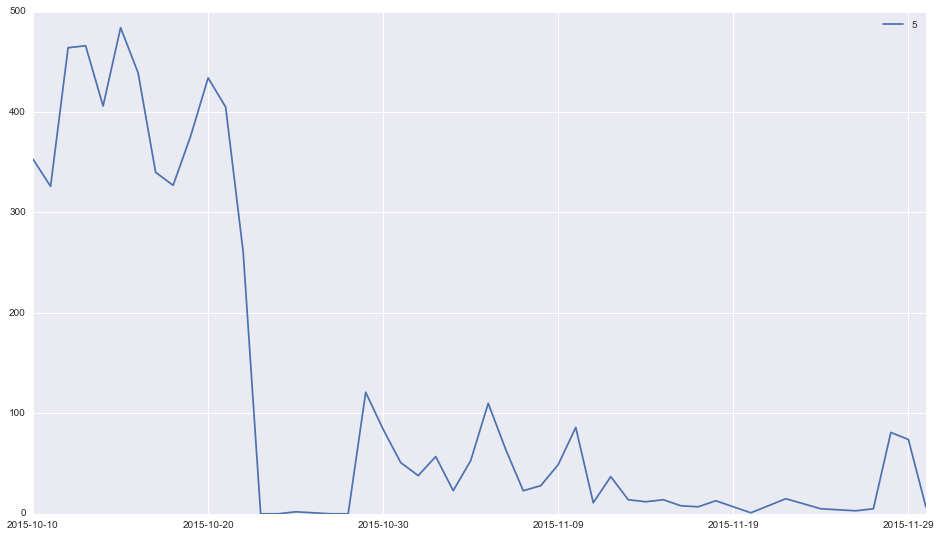

In [130]:
draw_id(5,start_date='2015-10-10',end_date='2015-11-30')

### 11.11 boost

In [138]:
double11_tune_test

,predict_11,predict_12,shop_level__0,shop_level__1,shop_level__2,score__-1.0,score__0.0,score__1.0,score__2.0,score__3.0,...,cate_3_name__其它小吃,cate_3_name__奶茶,cate_3_name__生鲜水果,cate_3_name__蛋糕,cate_3_name__西式快餐,cate_3_name__面包,cate_3_name__面点,cate_3_name__饮品/甜点,location_id,comment_cnt
1,240.760521,254.310000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,885,12.0
2,91.260104,134.690312,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,-1.0
3,87.281250,116.118021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,774,2.0
4,118.407292,194.083958,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380,-1.0
5,221.746563,226.635417,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,263,2.0
6,116.385937,113.439896,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1139,1.0
7,135.543125,172.400521,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,145,9.0
8,62.386458,76.076875,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,234,1.0
9,236.958542,253.240937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1120,0.0
10,100.984896,101.502396,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98,-1.0


In [135]:
double11_tune_test = result2.loc[:,'predict_11':'predict_12'].copy()

double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))
double11_tune_test = double11_tune_test.join(shop_info_num['location_id'])
double11_tune_test = double11_tune_test.join(shop_info_num['comment_cnt'])

In [139]:
RF11.predict(double11_tune_test)

array([ 71.9123381 ,  15.40994601, -17.29877247, ..., -43.29684382,
         5.80568067, -21.55284909])

In [145]:
double11_boost = pd.DataFrame(RF11.predict(double11_tune_test),index=range(1,2001),columns=['11boost']).join(pd.DataFrame(RF12.predict(double11_tune_test),index=range(1,2001),columns=['12boost']))

In [146]:
double11_boost

,11boost,12boost
1,71.912338,49.074938
2,15.409946,-7.643888
3,-17.298772,-32.013946
4,32.193341,-4.277591
5,-34.494966,-51.363926
6,-35.715138,-32.697793
7,48.200215,-6.020628
8,-10.581633,-19.751294
9,10.091684,-30.577112
10,-2.689473,-20.577372


In [ ]:
result2.loc[:,'predict_11'] += 0.1*double11_boost['11boost']
result2.loc[:,'predict_12'] += 0.1*double11_boost['12boost']

## 结果可视化

In [58]:
shop_info = shop_info.join(pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)]))
shop_info = shop_info.join(pd.DataFrame(result2,index=range(1,2001),columns=['predict_'+str(i) for i in range(8,15)]))

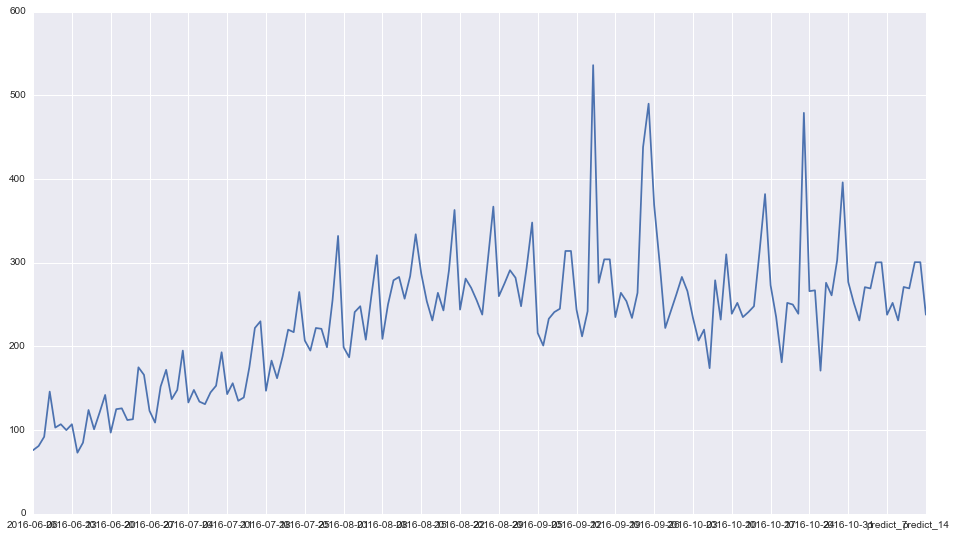

In [60]:

list_result = dateRange('2016-06-06','2016-10-31')
for i in range(1,15):
    list_result.append('predict_'+str(i))

xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
ax = plt.subplot(111) 
ax.xaxis.set_major_locator(xmajorLocator)
shop_info.loc[180,list_result].T.plot(figsize=(16,9),ax=ax)

In [48]:

#  占个格子 &&  cal avg sales count each day
total_day = pd.to_datetime('2016-11-01').date()-pd.to_datetime('2015-07-01').date() 
total_day = total_day.days
total_week = total_day / 7  # 69个
start_day = pd.to_datetime('2016-11-01').date() - datetime.timedelta(total_week*7)
#print start_day
for week_number in range(total_week): # 0~68
    start_day_of_week = start_day +  datetime.timedelta(week_number*7) 
    end_day_of_week = start_day_of_week + datetime.timedelta(6)
    start_day_of_week =   start_day_of_week.strftime("%Y-%m-%d")
    end_day_of_week = end_day_of_week.strftime("%Y-%m-%d")
    print start_day_of_week,end_day_of_week
    shop_info['wk_'+str(week_number)] = shop_info.loc[:,start_day_of_week:end_day_of_week].mean(axis=1)

2015-07-07 2015-07-13
2015-07-14 2015-07-20
2015-07-21 2015-07-27
2015-07-28 2015-08-03
2015-08-04 2015-08-10
2015-08-11 2015-08-17
2015-08-18 2015-08-24
2015-08-25 2015-08-31
2015-09-01 2015-09-07
2015-09-08 2015-09-14
2015-09-15 2015-09-21
2015-09-22 2015-09-28
2015-09-29 2015-10-05
2015-10-06 2015-10-12
2015-10-13 2015-10-19
2015-10-20 2015-10-26
2015-10-27 2015-11-02
2015-11-03 2015-11-09
2015-11-10 2015-11-16
2015-11-17 2015-11-23
2015-11-24 2015-11-30
2015-12-01 2015-12-07
2015-12-08 2015-12-14
2015-12-15 2015-12-21
2015-12-22 2015-12-28
2015-12-29 2016-01-04
2016-01-05 2016-01-11
2016-01-12 2016-01-18
2016-01-19 2016-01-25
2016-01-26 2016-02-01
2016-02-02 2016-02-08
2016-02-09 2016-02-15
2016-02-16 2016-02-22
2016-02-23 2016-02-29
2016-03-01 2016-03-07
2016-03-08 2016-03-14
2016-03-15 2016-03-21
2016-03-22 2016-03-28
2016-03-29 2016-04-04
2016-04-05 2016-04-11
2016-04-12 2016-04-18
2016-04-19 2016-04-25
2016-04-26 2016-05-02
2016-05-03 2016-05-09
2016-05-10 2016-05-16
2016-05-17

In [49]:
shop_info['result_avg'] = shop_info.loc[: ,['predict_'+str(i) for i in range(1,8)]].mean(axis=1)

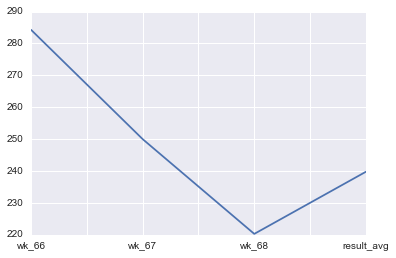

In [50]:
shop_info.loc[39,'wk_66':'result_avg'].plot()

In [ ]:
## 保存结果

In [61]:
result_total = result.join(result2)

In [62]:
for i in range(1,15):
    result_total.loc[:,'predict_'+str(i)] = result_total.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))
    

In [63]:
result_total.to_csv('regression_prediction_two_week(3 et).csv', sep=",", index = True)